# Reasons why using robust statistical techniques is preferable (on the example of the mean)
*This notebook is based on Rand R. Wilcox's textbook "Fundamentals of Modern Statistical Methods", which is an excellent place to begin learning robust statistical methods. The explanations in the book are very clear, and it contains a lot of practical advice on how to improve the accuracy of statistical analysis.*

Robust statistical methods are those that are effective even in the presence of outliers and heavy tail distributions. In such cases, classical statistical methods taught in introductory statistics courses typically produce unsatisfactory results. Furthermore, even minor deviations from normality can lead to incorrect conclusions when using classical methods. 

Robust statistics was developed in the 1960s in response to problems identified with classical statistical framework.

## Functions
The functions listed below will be required for our analysis.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.stats import trim_mean
from statsmodels.robust.scale import Huber
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def mixed_rvs(n, p=0.9, params1 = (0,1), params2 = (0,10)):
    """
    Generates random variables from a mixed normal distribution with two normal components.
    Args:
    n - integer, the size of the sample that will be generated.
    p - float, probability of the first normal component
    params1 - tuple, mean and std of the first normal component
    params2 - tuple, mean and std of the second normal component
    Returns:
    sample - np.array, generated sample   
    
    """
    a = np.random.rand(n,)
    # Determine the number of points from the first normal component
    cond = a < p
    n_first_comp = len(a[cond])
    # Determine the number of points from the second normal component
    n_second_comp = n-n_first_comp
        
    # Generate points
    sample1 = norm.rvs(loc=params1[0], scale=params1[1], size=n_first_comp)
    sample2 = norm.rvs(loc=params2[0], scale=params2[1], size=n_second_comp)
    
    return np.concatenate([sample1, sample2])  

In [3]:
def sampling_distribution(distr, statistics, n, number_of_samples, distr_params=(0,1), proportiontocut=0.2):
    """
    Draws a sampling distribution for chosen statistics
    Args:
    distr - a string with only two values: 'norm' and 'mixed norm'; the distribution of an analyzed random variable
    statistics - list of strings: 'mean', 'median', 'trimmed mean', 'huber'; 
                 statistics for which a sampling distribution will be built
    n - int, number of observations in each sample
    number_of_samples - int, number of simulations
    distr_params - tuple, normal distribution parameters
    proportiontocut - float, a trimmed mean parameter
    """
    
    statistic_functions = {'mean': np.mean,
                           'median': np.median,
                           'trimmed mean': trim_mean,
                           'huber': Huber
                           }
    
    colors = ['mediumblue', 'red', 'black', 'orange']
    
    statistic_vals = np.empty((number_of_samples,len(statistics)))
    statistic_vals.fill(np.nan)
    
    plt.figure(figsize=(7,5))
    for i in range(number_of_samples):
        if distr == 'norm':
            sample = norm.rvs(loc=distr_params[0], scale=distr_params[1], size=n)
            plt.title('Sampling Distribution for Normal Random Variable', fontsize=14)
        else:
            sample = mixed_rvs(n)
            plt.title('Sampling Distribution for Mixed Normal Random Variable', fontsize=14)
        
        for j in range(len(statistics)):
            stat = statistics[j]
            func = statistic_functions[stat]
            if stat == 'trimmed mean':
                statistic_vals[i,j]=func(sample,proportiontocut)
            elif stat == 'huber':
                statistic_vals[i,j]=func(maxiter=1000)(sample)[0].item()
            else:
                statistic_vals[i,j]=func(sample)
            
    
    
    for i in range(len(statistics)):
        pdf = sns.distplot(statistic_vals[:,i], hist=False,label=statistics[i], color = colors[i])        

## Mean is not robust
When we explore data, we try to figure out what is a typical or central observation in order to better understand the data. We frequently use an average to describe the typical data point.

The problem with using the average is that it is very susceptible to outliers. Even a single outlier can significantly alter the average. For example, compare the average for the sample {1,2,3,4,5,6,7} and the average for the sample {1,2,3,4,5,6,7,100}.

The related issue is that the variance is also highly susceptible to outliers. As we know, the accuracy of a mean estimate is defined by a standard error  which is calculated as a square root of variance divided by a sample size. In the presence of outliers, the variance and standard error will be very large. As a result, when we have outliers, our estimation of the mean is not accurate.

A median, which is resistant to outliers, is an obvious alternative to the mean. To begin, let's compare the accuracy of sample estimates of mean and median for a random variable drawn from a normal distribution.

### Accuracy of mean and median estimates for a normally distributed random variable

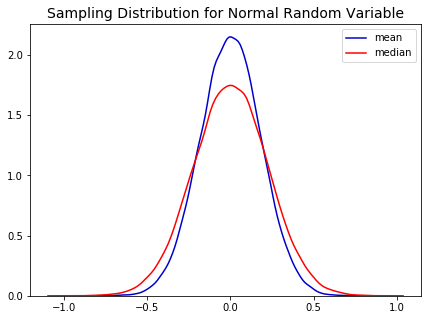

In [4]:
# To create a sampling distribution, we take 50000 samples from a standard normal distribution, 
# with 30 points in each sample.
# We estimate the mean for each of these samples. As a result, we have 50000 means.
# Sampling distribution is a distribution of 50000 mean estimates.
n=30
number_of_samples=50000
sampling_distribution('norm', ['mean', 'median'], n, number_of_samples)

The sampling distribution for the mean is narrower than that for the median, as shown by the plot above. This indicates that the measure of the central tendency for a normal random variable is more accurately represented by the mean estimate. We can see that the probability of getting a mean estimate that is significantly different from the true value of zero — for instance, a mean estimate greater than 0.5 — is negligible. However, the probability of getting a median greater than 0.5 is not negligible.

Let's examine what happens to the mean and median estimates if the distribution of the analyzed random variable deviates from normal in a non-significant way. We use a mixed normal distribution as a distribution that is close to normal.

### Mixed normal distribution
Mixed normal distribution consists of observations from two normal distributions whith different parameters. The ratio of the two different types of observations is a mixed distribution parameter.

The mixed normal distribution shown in the example below is composed of 90% standard normal distribution and 10% normal distribution with parameters (mu = 0, std = 10).

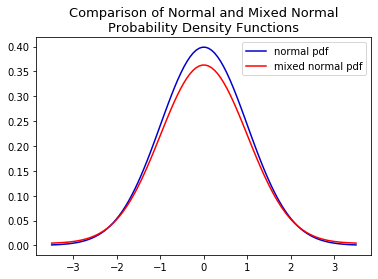

In [5]:
x = np.linspace(-3.5, 3.5, 100)

# Standard normal distribution 
plt.plot(x, norm.pdf(x), color='mediumblue', label='normal pdf')

# Mixed normal distribution
plt.plot(x, 0.9*norm.pdf(x) + 0.1*norm.pdf(x,0,10), 'r-', label='mixed normal pdf')

plt.legend()
plt.title('Comparison of Normal and Mixed Normal\nProbability Density Functions', fontsize=13);

As we can see, the mixed normal distribution deviates from the normal distribution quite insignificantly. It would be interesting to look into how this small deviation affects the accuracy of mean and median estimates.

### Accuracy of mean and median estimates for the mixed normal distribution

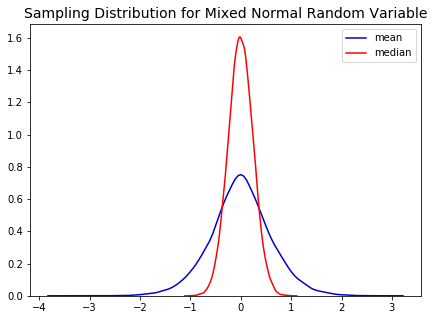

In [6]:
sampling_distribution('mixed norm', ['mean', 'median'], n, number_of_samples)

Minor deviations from normality have a significant impact on the accuracy of the mean estimate. We now have a high probability of getting mean estimates that are far from the true central tendency=0. For example, the probaility of getting a mean estimate greater than 1 or less than -1 is quite high. To summarize the plot's findings, we have a random variable with symmetrical and very close to normal distribution, but for which a mean is an inadequate measure of central tendency. The reason for this is that the distribution has heavier tails than normal. Outliers have a large impact on variance and, as a result, on a standard error of the mean.

We can see that for a normal distribution, a mean is the best estimate of central tendency, whereas for a mixed normal distribution, a median is the best estimate. As a result, we must devise a new estimate of central tendency that is somewhere between mean and median and works effectively for both types of distributions.

**A trimmed mean, which is a robust measure, is one such estimate of central tendency.**

## Trimmed mean
The trimmed mean is a natural choice for a measure between mean and median. It avoids outliers by removing the most extreme and smallest outliers. It was discovered that removing 20% of the largest and 20% of the smallest values yields a measure that is suitable for general use.

### Accuracy of a trimmed mean estimate for the mixed normal distribution

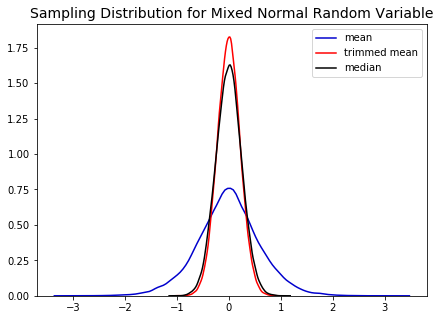

In [7]:
sampling_distribution('mixed norm', ['mean', 'trimmed mean', 'median'], n, number_of_samples)

We can see that for the mixed normal distribution, the trimmed mean outperforms even the median.

### Accuracy of a trimmed mean estimate for the normal distribution

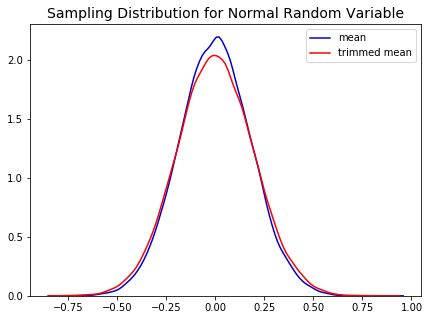

In [8]:
sampling_distribution('norm', ['mean', 'trimmed mean'], n, number_of_samples)

The normal distribution mean outperforms the trimmed mean in terms of accuracy, but the difference is insignificant.

## Further implications

The fact that the mean is not a robust measure has a negative impact on statistical methods based on means, such as outlier detection, hypothesis testing, correlation estimates, and regression.

The example below shows how the power of hypothesis testing is reduced. The reason for the lower power is that power depends inversely on the variance. And outliers inflate variance.

### Implications on power when comparing two means
In hypothesis testing with two means, power is a probability of detecting a difference between means when such a difference exists.

Assume that we have two independent groups for which we need to compare means.

#### Power of a test when two compared groups are sampled from the normal distribution
We assume that both groups were drawn from normal distributions with a variance of one. The first distribution has a mean of zero, while the second has a mean of one. The plot below depicts the pdfs of these two distributions.

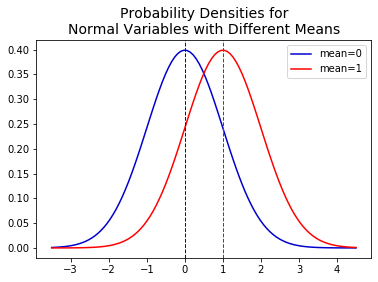

In [9]:
# Standard Normal 
x = np.linspace(-3.5, 4.5, 100)
plt.plot(x, norm.pdf(x), color='mediumblue', label='mean=0')
plt.plot(x, norm.pdf(x,1,1), color='red', label='mean=1')
plt.axvline(x=0, color='mediumblue', lw=1, linestyle='--')
plt.axvline(x=1, color='red', lw=1, linestyle='--')
plt.legend()
plt.title('Probability Densities for\nNormal Variables with Different Means', fontsize=14);

For this example we can simulate the test results and estimate the power.

In [10]:
sample_size=30
n=10000
p_values = np.empty(n,)
p_values.fill(np.nan)
for i in range(n):
    p_values[i] = ttest_ind(norm.rvs(loc=0, scale=1, size=sample_size), 
                            norm.rvs(loc=1, scale=1, size=sample_size)).pvalue

prob = 1-len(p_values[p_values > 0.05])/n    
print("Probability of detecting the difference in the means {}%".format(round(prob*100,2)))

Probability of detecting the difference in the means 96.76%


**Normal distribution**: When we use the Student t test at the 5% level and sample 30 observations in each simulation, we have a 97% chance of detecting the difference between means.

#### Power of a test when two compared groups are sampled from the mixed normal distribution
We assume that both groups were drawn from mixed normal distributions. The first distribution has a mean of zero, while the second has a mean of one. The plot below depicts the pdfs of these two distributions.

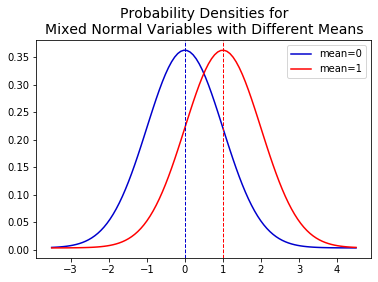

In [11]:
# Mixed Normal 
x = np.linspace(-3.5, 4.5, 100)
plt.plot(x, 0.9*norm.pdf(x) + 0.1*norm.pdf(x,0,10), color='mediumblue', label='mean=0')
plt.plot(x, 0.9*norm.pdf(x,1,1) + 0.1*norm.pdf(x,1,10), color='red', label='mean=1')
plt.axvline(x=0, color='mediumblue', lw=1, linestyle='--')
plt.axvline(x=1, color='red', lw=1, linestyle='--')
plt.legend()
plt.title('Probability Densities for\nMixed Normal Variables with Different Means', fontsize=14);

In [12]:
p_values = np.empty(n,)
p_values.fill(np.nan)
for i in range(n):
    p_values[i] = ttest_ind(mixed_rvs(sample_size), 
                            mixed_rvs(n=sample_size, params1 = (1,1), params2 = (1,10))).pvalue
prob = 1-len(p_values[p_values > 0.05])/n    
print("Probability of detecting the difference in the means {}%".format(round(prob*100,2)))

Probability of detecting the difference in the means 29.77%


**Mixed normal distribution**: When we use the Student t test at the 5% level and sample 30 observations in each simulation, we have just a 30% chance of detecting the difference between means.

## References
Wilcox R.R. (2010). Fundamentals of Modern Statistical Methods. Springer